# Implementation of Kaczmarz algorithm for updating the expansion coefficients in a Polynomial regression

In [19]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import random
from sklearn.preprocessing import PolynomialFeatures

#New! for Legendre
from scipy.special import legendre
from sklearn.metrics import r2_score #for r-squared

### Previous (disregard, for personal record only)

In [20]:
## Function to generate polynomial features using monomial basis functions
## This function can be also defined using a for loop and plain NumPy

def generate_design_matrix_from_1D_data(x_initial,polynomial_order):
    """
    Input: 
    x_initial: shape=(N,) where 'N' is the number of samples
    polynomial_order: scalar: the order of polynomial you want to fit to the data
    
    ouput: design_matrix: shape=(N,polynomial_order+1)
    """
    # Check if x_initial is a scalar
    if np.isscalar(x_initial):
        # If it is, convert it to a numpy array
        x_initial = np.array([x_initial])
    elif isinstance(x_initial, list):
        # If it is a list, convert it to a numpy array
        x_initial = np.array(x_initial)

        
    
    # Generate the polynomial features using sklearn_preprocessing package
    poly_features=PolynomialFeatures(degree=polynomial_order)

    # Update the design matrix using the polynomial features created in the previous step
    design_matrix=poly_features.fit_transform(x_initial.reshape(-1,1))

    return design_matrix

In [21]:
def online_kaczmarz_legendre_multiple_input(input_data, target_values, polynomial_degree, input_indices, weights=None):

    
    beta_parameter = 0
    
    if weights is None:
        weight_predictions = np.random.rand(polynomial_degree+1) #polynomial order starting from 0
    else:
       weight_predictions = weights


    y = target_values # scalar, the y that corresponds to the observed x
    # print('y: ', y.shape)


    for i in range (input_data.shape[0]):
            for j in range(polynomial_degree+1):
                x = generate_legendre_design_matrix(input_data[:,input_indices[j]], polynomial_degree)
                a = x[-1,:]
                
                weight_predictions = weight_predictions + ((y[i] - np.dot(a, weight_predictions)) / np.linalg.norm(a)**2) * a.T

                # This is for beta

                # residual_errors = target_values - design_matrix @ weight_predictions
                # sse = residual_errors.T @ residual_errors
                # beta_parameter = sse / ( - polynomial_order)

    return weight_predictions, beta_parameter

In [22]:
# Generate random design matrix and target values
np.random.seed(14)  # for reproducibility
design_matrix_ = np.random.rand(10, 2)  # 10 samples, 2 input vectors
target_values = np.random.rand(10)

# Set polynomial degree
polynomial_degree = 3
input_indices = [0, 0, 1, 0]

# Call the function
weight_predictions, beta_parameter = online_kaczmarz_legendre_multiple_input(design_matrix_, target_values, polynomial_degree, input_indices,)
print('weight_predictions: ', weight_predictions)

weight_predictions:  [ 0.36530164 -0.31048627  0.5621633   0.09310512]


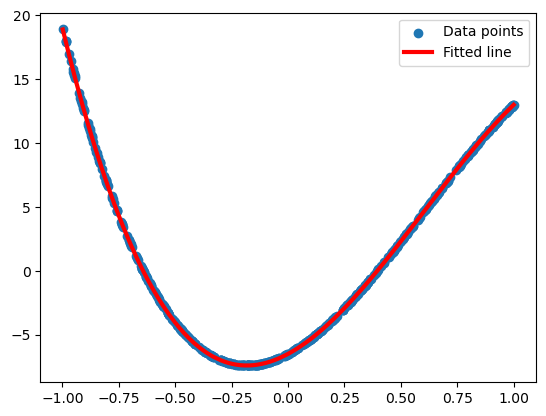

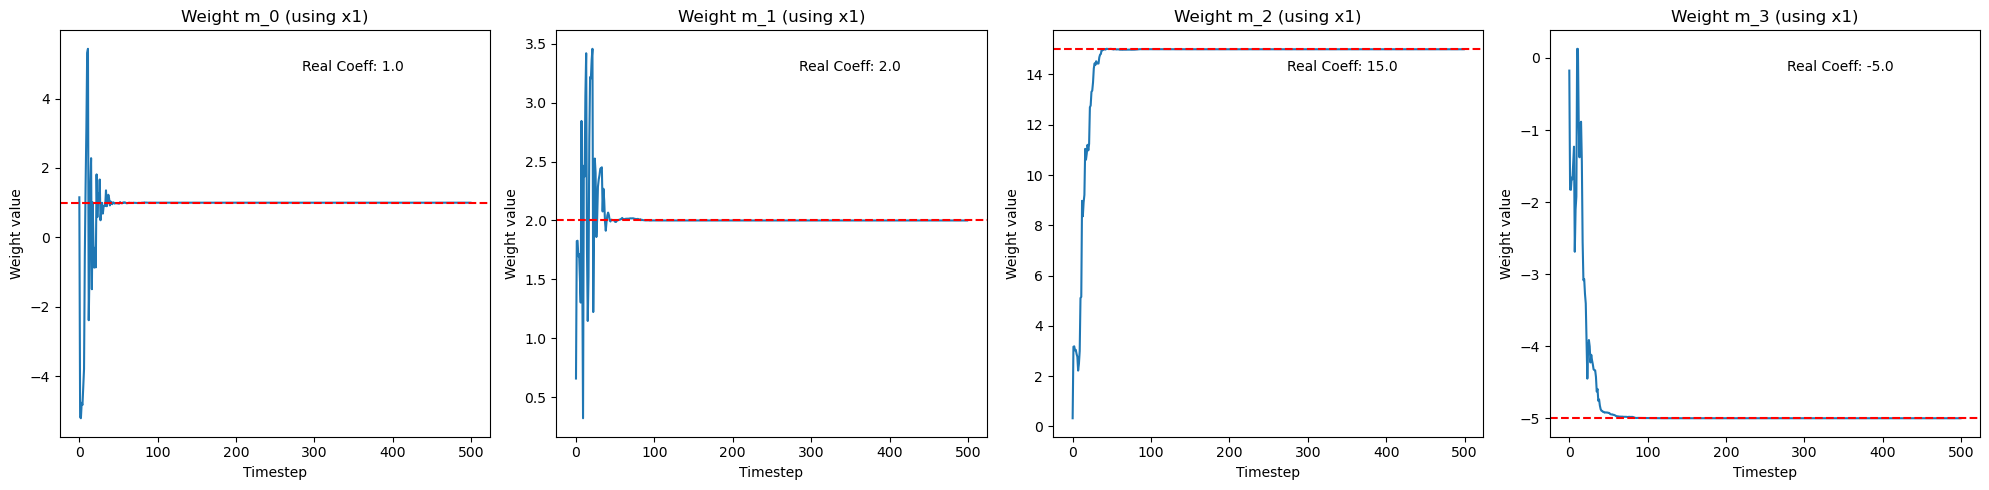

In [23]:

################################################################################################
####    Definition of "Hyperparameters"
################################################################################################

t = 500 # Number of points to be generated, and times the coefficients will be updated.
        # The coefficients w are calculatd for each of these points, the idea is to simulate an on-line stream of data. 

# Generate all x upfront
"""
    Update this if using more input variables, # the function should be able to handle more than 2
"""
X = 2 * np.random.rand(t, 2) - 1
x1, x2 = X[:, 0], X[:, 1]                 

polynomial_degree = 3

# Legendre Polynomials
P_0 = 1
P_1 = x1
P_2 = 1/2 * (3*x1**2 - 1)
P_3 = 1/2 * (5*x1**3 - 3*x1)

# Argument that indicates the function what input variable (x1, x2, ...) corresponds to what polynomial P_n
"""
    Update the input indices accordingly!
    0 --> x1
    1 --> x2
    and so on
"""
input_indices = [0, 0, 0, 0]

real_coeffs   = [1, 2, 15, -5]    # These are the real coefficients, what the estimated w should converge to. 

# Generate Y as target_values (real Y's)
noise = np.random.normal(scale= 0.1 , size=(t))
target_values = real_coeffs[0] * P_0 + real_coeffs[1] * P_1 + real_coeffs[2] * P_2 + real_coeffs[3] * P_3 #+ noise



# Initialize weights 
weights_over_time = []


################################################################################################
####    Online estimation of coefficients
################################################################################################


for i in range(X.shape[0]):
    if i == 0:
        weight_predictions, _ = online_kaczmarz_legendre_multiple_input(X[i,:].reshape(1, -1), np.array([target_values[i]]), polynomial_degree, input_indices)
    else:
        weight_predictions, _ = online_kaczmarz_legendre_multiple_input(X[i,:].reshape(1, -1), np.array([target_values[i]]), polynomial_degree, input_indices, weight_predictions)
    
    weights_over_time.append(weight_predictions)

weights_over_time = np.array(weights_over_time)


################################################################################################
####    Results
################################################################################################

x_ = x1

# Use last predicted weights to compute y_hat
weights = weights_over_time[-1]
y_hat = generate_legendre_design_matrix(x_, polynomial_degree) @ weights.T



################################################################################################
####    Plots and graphs
################################################################################################


# Sort the data by x
sort_indices = np.argsort(x_[:])
x_sorted = x_[sort_indices]
y_hat_sorted = y_hat[sort_indices]

# Plot the fitted line
plt.scatter(x_, target_values, label='Data points')
plt.plot(x_sorted, y_hat_sorted, color='red', linewidth = 3, label='Fitted line')
plt.legend()
plt.show()

"""# Plot the accuracy
r2 = r2_score(target_values, y_hat)
plt.scatter(target_values, y_hat)
plt.plot(target_values, target_values, color='red', linewidth = 3, label=f'Y=Y_hat, \nR^2  = {r2:.2f}')
plt.legend() 
plt.show()"""

# Create a grid of horizontal subplots, one for each weight
fig, axs = plt.subplots(ncols=polynomial_degree+1, figsize=(20, 5))

for i in range(polynomial_degree+1):
    axs[i].plot(weights_over_time[:, i])
    axs[i].set_title(f'Weight m_{i} (using x{input_indices[i]+1})')
    mean_value = real_coeffs[i]
    axs[i].axhline(y=mean_value, linestyle='dashed', color='red')
    axs[i].text(0.8, 0.9, f"Real Coeff: {mean_value:.1f}", transform=axs[i].transAxes, ha='right')
    axs[i].set_xlabel('Timestep')
    axs[i].set_ylabel('Weight value')

plt.tight_layout()
plt.show()

In [24]:
# For this, consider the "interaction" of the different input variables. It is as if you have several dimensions. Take a look into max and total degree.
# This information is in the picture of the board of the professor. 
# Check total order vs maximum order. More commonly, we use total order = summation of these. Pick less. 

## Multiple Input  - Single Output

### Legendre Polynomials

The general formula for the Legendre polynomials is given by Rodrigues' formula:

### $$ P_n(x) = \frac{1}{2^n n!} \frac{d^n}{dx^n} \left[ (x^2 - 1)^n \right] $$


where:

- $P_n(x)$ is the Legendre polynomial of degree $n$,
- $n$ is a non-negative integer,
- $x$ is the variable,
- $\frac{d^n}{dx^n}$ denotes the $n_{th}$ derivative,
- and $n!$ is the factorial of $n$.


The first 4 Legendre polynomials are as follows:

\begin{align*}
P_0 &= 1 \\
P_1 &= x \\
P_2 &= \frac{1}{2} \left(3x^2 - 1\right) \\
P_3 &= \frac{1}{2} \left(5x^3 - 3x\right)
\end{align*}

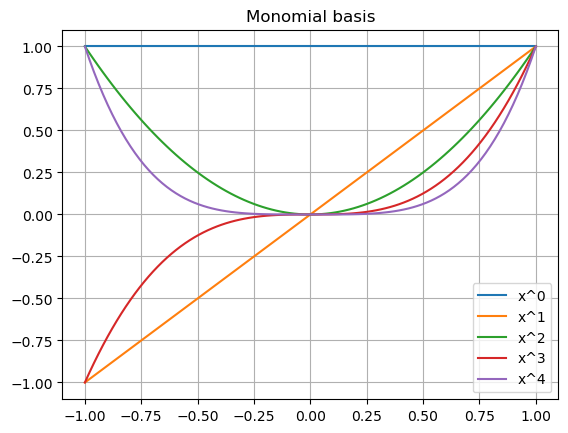

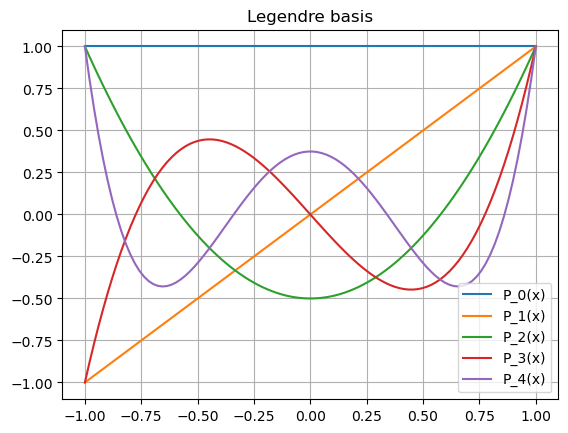

In [25]:
def generate_legendre_design_matrix(x_initial, polynomial_order):
    # If x_initial is a single number, convert it to a numpy array
    if np.isscalar(x_initial):
        x_initial = np.array([x_initial])
        
    N = len(x_initial)
    design_matrix = np.ones((N, polynomial_order + 1), dtype='float64')
    
    for j in range(polynomial_order + 1):
        P_j = legendre(j)
        for i in range(N):
            design_matrix[i, j] = P_j(x_initial[i])
            
    return design_matrix

def legendre_polynomials(x_values):
    results = []
    for x in x_values:
        P0 = 1
        P1 = x
        P2 = (-1 + 3*x**2) / 2
        P3 = (-3*x + 5*x**3) / 2
        P4 = (3 - 30*x**2 + 35*x**4) / 8
        results.append((P0, P1, P2, P3, P4))
    return np.array([results])


x_initial = np.linspace(-1, 1, 100)
polynomial_order = 4

monomial_matrix = generate_design_matrix_from_1D_data(x_initial, polynomial_order)
legendre_matrix = generate_legendre_design_matrix(x_initial, polynomial_order)

# Plot monomial polynomials
for j in range(polynomial_order + 1):
    plt.plot(x_initial, monomial_matrix[:, j], label=f"x^{j}")
plt.title("Monomial basis")
plt.legend()
plt.grid(True)
plt.show()

# Plot Legendre polynomials
for j in range(polynomial_order + 1):
    plt.plot(x_initial, legendre_matrix[:, j], label=f"P_{j}(x)")
plt.title("Legendre basis")
plt.legend()
plt.grid(True)
plt.show()

### Design Matrix with multiple input variables

In this section, the functions for generating a multiple input design matrix and updating the weights using the Kaczmarz algorithm are defined and explained



The `generate_multi_legendre_design_matrix` function begins by verifying whether the `x_initial` is a *scalar value*. If it is indeed a scalar, the function will convert it into a *2D array*. This design ensures that the function can handle *individual numbers as input*, not just arrays.

Next, the function performs a check to ascertain whether the input possesses at least *two dimensions*. In cases where it does not, the function adds an *extra dimension*. This dimension addition is necessary for managing *multiple variables* effectively.

The shape of `x_initial` is then stored in two variables, `N` and `num_vars`, which represent the *number of data points* and the *number of variables*, respectively. The number of terms in the polynomial for each variable is stored in `n_expansion_terms`, and the total number of terms in the polynomial, calculated as `n_expansion_terms ** num_vars`, is stored in `total_expansion_terms`.

A *design matrix*, with `N` rows and `total_expansion_terms` columns, is then initialized. This matrix will contain the evaluations of *Legendre polynomials* at the provided data points.

The function then embarks on a *nested loop* to populate the design matrix. The outer loop iterates over each data point. For every data point, the inner loop iterates over all combinations of polynomial orders for each variable. This iteration is achieved through the use of `np.ndindex(*([n_expansion_terms]*num_vars))`.

In every iteration of the inner loop, a *product of Legendre polynomials* is computed. For each variable, the Legendre polynomial of the corresponding order is evaluated at the value of the variable for the current data point. This value is then multiplied into the product.

Ultimately, the calculated product is stored into the *design matrix* and the process is repeated for the next combination of polynomial orders. Once all combinations have been processed for a data point, the function moves on to the next data point. This process continues until the design matrix is completely populated.


In [26]:
# (x1^0 * X2^0) + (x1^1 * X2^0) + (x1^2 * X2^0) + 
# (x1^0 * X2^1) + (x1^1 * X2^1) + (x1^2 * X2^1) + 
# (x1^0 * X2^2) + (x1^1 * X2^2) + (x1^2 * X2^2)

#### USING MAX (vs. Total) EXPANSION TERMS

**Number of terms in the weights matrix:**

The number of terms in the weights matrix can be calculated using the formula:

$$
(\text{Polynomial Order} + 1)^{\text{\# of input variables}}
$$

For example, if the polynomial order is 2 and there are 2 input variables, the number of terms in the weights matrix would be:

$$
(2 + 1)^2 = 9
$$


In [27]:
def generate_multi_legendre_design_matrix(x_initial, polynomial_order):
    if np.isscalar(x_initial):
        x_initial = np.array([[x_initial]])

    # Ensure x_initial is a 2D numpy array
    x_initial = np.atleast_2d(x_initial)
    

    # N is the number of observations,      num_vars is the number of input variables
    N, n_input_vars = x_initial.shape

    # Number of terms in the expansion for each variable (x1^0, x1^1, x1^2, ...)
    n_expansion_terms = polynomial_order + 1

    # Total number of terms in the expansion
    total_expansion_terms = n_expansion_terms ** n_input_vars

    # Initialize design matrix
    design_matrix = np.empty((N, total_expansion_terms), dtype='float64')

    # Loop over each data point
    for i in range(N):
        col_index = 0 # just a counter
        # Loop over all combinations of polynomial orders for each variable
        for terms in np.ndindex(*([n_expansion_terms]*n_input_vars)): ######## CHECK
            product = 1.0
            # Calculate the product of Legendre polynomials for this combination of terms
            for var in range(n_input_vars):
                P_j = legendre(terms[var])
                product *= P_j(x_initial[i, var])
            # Store result in the design matrix
            design_matrix[i, col_index] = product
            col_index += 1
            
    return design_matrix

If we set `n_expansion_terms = 3` and `n_input_vars = 2`, the loop `for terms in np.ndindex(*([n_expansion_terms]*n_input_vars))` will iterate over tuples representing polynomial terms. The tuples generated in this case would be:

- `(0, 0)` corresponding to $u^{0} \cdot v^{0}$
- `(0, 1)` corresponding to $u^{0} \cdot v^{1}$
- `(0, 2)` corresponding to $u^{0} \cdot v^{2}$
- `(1, 0)` corresponding to $u^{1} \cdot v^{0}$
- `(1, 1)` corresponding to $u^{1} \cdot v^{1}$
- `(1, 2)` corresponding to $u^{1} \cdot v^{2}$
- `(2, 0)` corresponding to $u^{2} \cdot v^{0}$
- `(2, 1)` corresponding to $u^{2} \cdot v^{1}$
- `(2, 2)` corresponding to $u^{2} \cdot v^{2}$

Each tuple represents the degree of the polynomial term for each input variable.


If we have `n_expaction_terms=3` and `n_input_vars=3`, then the Python expression `np.ndindex(*([n_expaction_terms]*n_input_vars))` generates all combinations of indices for a 3-dimensional array with dimensions 3x3x3. In this specific case, the iterator would produce a total of 27 tuples, as 3^3 equals 27. These tuples represent all possible combinations of polynomial terms for three distinct variables.

The tuples generated by this iterator stand for the polynomial degrees for our three variables, conventionally named `x`, `y`, and `z`. To illustrate, the tuple `(0, 1, 2)` would correspond to a term in the polynomial of the form x<sup>0</sup> * y<sup>1</sup> * z<sup>2</sup>.

Below, we list all tuples that would be generated in this scenario:

- `(0, 0, 0)`
- `(0, 0, 1)`
- `(0, 0, 2)`
- `(0, 1, 0)`
- `(0, 1, 1)`
- `(0, 1, 2)`
- `...`

And so on, until we get to 
- `(2, 2, 0)`
- `(2, 2, 1)`
- `(2, 2, 2)`

Each tuple (i, j, k) can be thought of as a term in the polynomial of the form  x<sup>i</sup> * y<sup>j</sup> * z<sup>k</sup>.



In [28]:
def online_kaczmarz_legendre_multiple(x_initial, target_values, polynomial_order, weights=None):

    design_matrix = generate_multi_legendre_design_matrix(x_initial, polynomial_order)

    if weights is None:
        # initialize the weights to be the number of columns in the design matrix
        weight_predictions = np.random.rand(design_matrix.shape[1])
    else:
        weight_predictions = weights

    beta_parameter = 0

    for i in range (design_matrix.shape[0]):
        a = design_matrix[i, :]
        weight_predictions = weight_predictions + ((target_values[i] - np.dot(a, weight_predictions)) / np.linalg.norm(a)**2) * a.T

        # This is for beta
        # Note: you may want to uncomment this if you want to compute beta_parameter
        # residual_errors = target_values - design_matrix @ weight_predictions
        # sse = residual_errors.T @ residual_errors
        # beta_parameter = sse / ( - polynomial_order)

    return weight_predictions, beta_parameter

### Tests

In [29]:

################################################################################################
####    Definition of "Hyperparameters"
################################################################################################

t = 500 # Number of points to be generated, and times the coefficients will be updated.
        # The coefficients w are calculatd for each of these points, the idea is to simulate an on-line stream of data. 

# Generate all x upfront
"""
    Update this if using more input variables, # the function should be able to handle more than 2
"""
X = 2 * np.random.rand(t, 2) - 1
x1, x2= X[:, 0], X[:, 1]               

polynomial_degree = 2

"""
    USING MAX (vs. Total) EXPANCTION TERMS
    Number of terms in the weights matrix: 
    (Poynomial Order + 1) ** # of input variables
    (2+1)^2
"""

                        #     x2   
                        # ^0, ^1,  ^2
real_coeffs   = np.array([1,   2,   2,  #x1^0
                          2,   4,   7,  #x1^1
                          3,   5,   3]) #x1^2   
# These are the real coefficients, what the estimated w should converge to.


# Generate Y as target_values (real Y's)
noise = np.random.normal(scale= 0.1 , size=(t))

target_values = generate_multi_legendre_design_matrix(X, polynomial_degree) @ real_coeffs.T         # + noise


# Initialize weights 
weights_over_time = []


################################################################################################
####    Online estimation of coefficients
################################################################################################


for i in range(t):
    if i == 0:
        weight_predictions, _ = online_kaczmarz_legendre_multiple(X[i,:], np.array([target_values[i]]), polynomial_degree)
    else:
        weight_predictions, _ = online_kaczmarz_legendre_multiple(X[i,:], np.array([target_values[i]]), polynomial_degree, weight_predictions)
    
    weights_over_time.append(weight_predictions)

weights_over_time = np.array(weights_over_time)

print('weights_over_time: ', weights_over_time.shape)

weight = weights_over_time[-1]
Weights = pd.DataFrame({
    'Real_Weights': real_coeffs,
    'Estimated_Weights': weight
})

# Style DataFrame
Weights.style.format("{:.4f}")

weights_over_time:  (500, 9)


,Real_Weights,Estimated_Weights
0,1.0000,0.9996
1,2.0000,2.0002
2,2.0000,2.0002
3,2.0000,1.9999
4,4.0000,4.0001
5,7.0000,6.9995
6,3.0000,3.0004
7,5.0000,5.0006
8,3.0000,3.0023


In [30]:
################################################################################################
####    Results
################################################################################################

# Use last predicted weights to compute y_hat
y_hat = generate_multi_legendre_design_matrix(X, polynomial_degree) @ weight.T

Predicted_Values = y_hat[-10:]
Real_Values = target_values[-10:]
difference = (Real_Values-Predicted_Values).T


Y = pd.DataFrame({
    'Predicted_Values': Predicted_Values,
    'Real_Values': Real_Values,
    'Difference': difference
})

# Style DataFrame
Y.style.format("{:.4f}")

,Predicted_Values,Real_Values,Difference
0,-0.0966,-0.0962,0.0003
1,-0.0912,-0.0908,0.0003
2,-0.9283,-0.9284,-0.0001
3,-0.9326,-0.9322,0.0004
4,0.2897,0.2902,0.0005
5,0.8439,0.8452,0.0013
6,1.0747,1.0755,0.0007
7,-0.2722,-0.2718,0.0004
8,-1.1223,-1.1222,0.0001
9,8.4132,8.4132,0.0000


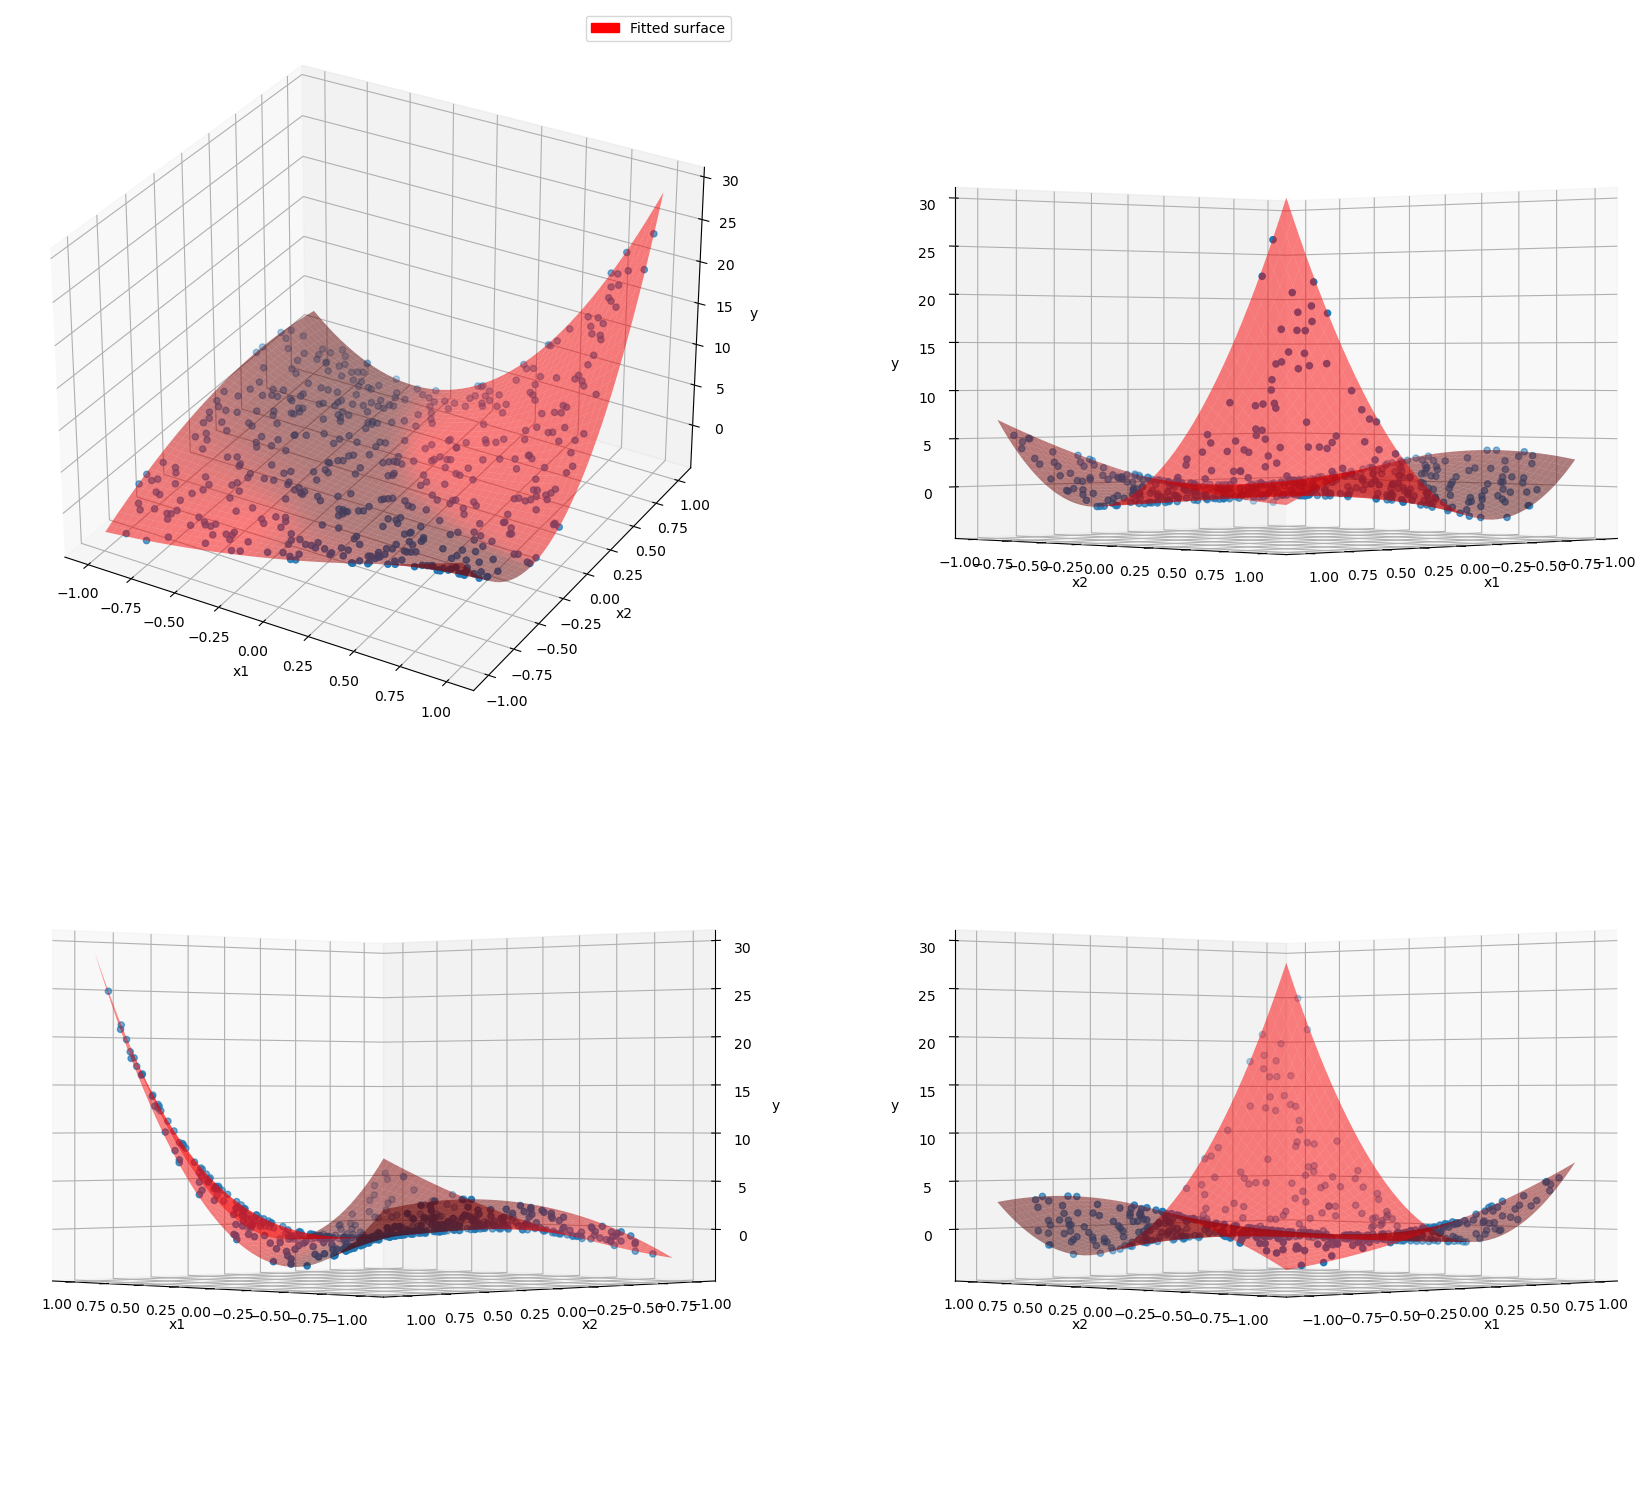

In [31]:
#### Only use when you have 2 input variables, plot something using this cell.


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

# Create a figure
fig = plt.figure(figsize=(20, 15))

# Create a 3D subplot for the original 3D plot
ax1 = fig.add_subplot(221, projection='3d')

# Scatter plot of the original data points
ax1.scatter(x1, x2, target_values, label='Data points')

# Generate a grid over the input space to plot the surface
x1_range = np.linspace(x1.min(), x1.max(), num=50)
x2_range = np.linspace(x2.min(), x2.max(), num=50)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)

# Generate y_hat over the grid
X_grid = np.vstack([x1_grid.flatten(), x2_grid.flatten()]).T
y_hat_grid = generate_multi_legendre_design_matrix(X_grid, polynomial_degree) @ weight.T
y_hat_grid = y_hat_grid.reshape(x1_grid.shape)

# Plot the fitted surface
surf = ax1.plot_surface(x1_grid, x2_grid, y_hat_grid, color='red', alpha=0.5)

# Create a patch for the surface and add it to the legend
red_patch = mpatches.Patch(color='red', label='Fitted surface')
ax1.legend(handles=[red_patch])

ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y')

# Create rotated 3D plots
angles = [ (0, 45), (0, 45+90), (0, 45+180)]
for i, angle in enumerate(angles, start=2):
    ax = fig.add_subplot(2,2, i, projection='3d')
    ax.scatter(x1, x2, target_values, label='Data points')
    ax.plot_surface(x1_grid, x2_grid, y_hat_grid, color='red', alpha=0.5)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('y')
    ax.view_init(*angle)

plt.tight_layout()
plt.show()


r2:  0.9999999683155999


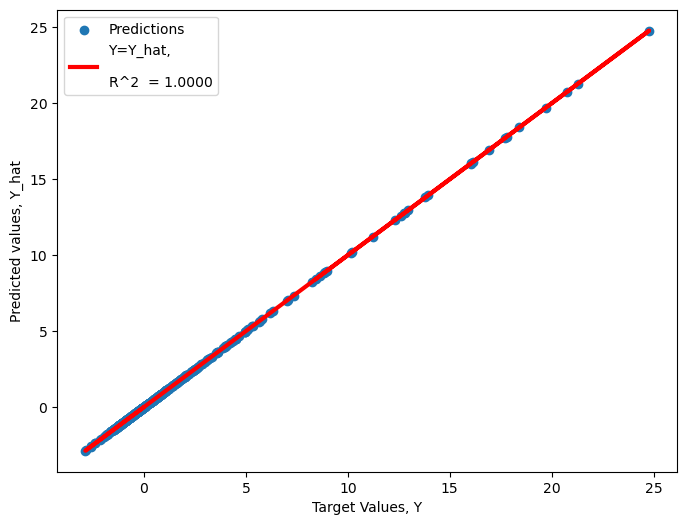

In [32]:
# Plot the accuracy
plt.figure(figsize=(8, 6))
r2 = r2_score(target_values, y_hat)
print('r2: ', r2)
plt.scatter(target_values, y_hat, label='Predictions')
plt.plot(target_values, target_values, color='red', linewidth = 3, label=f'Y=Y_hat, \n\nR^2  = {r2:.4f}')
plt.xlabel('Target Values, Y')
plt.ylabel('Predicted values, Y_hat')
plt.legend()
plt.show()

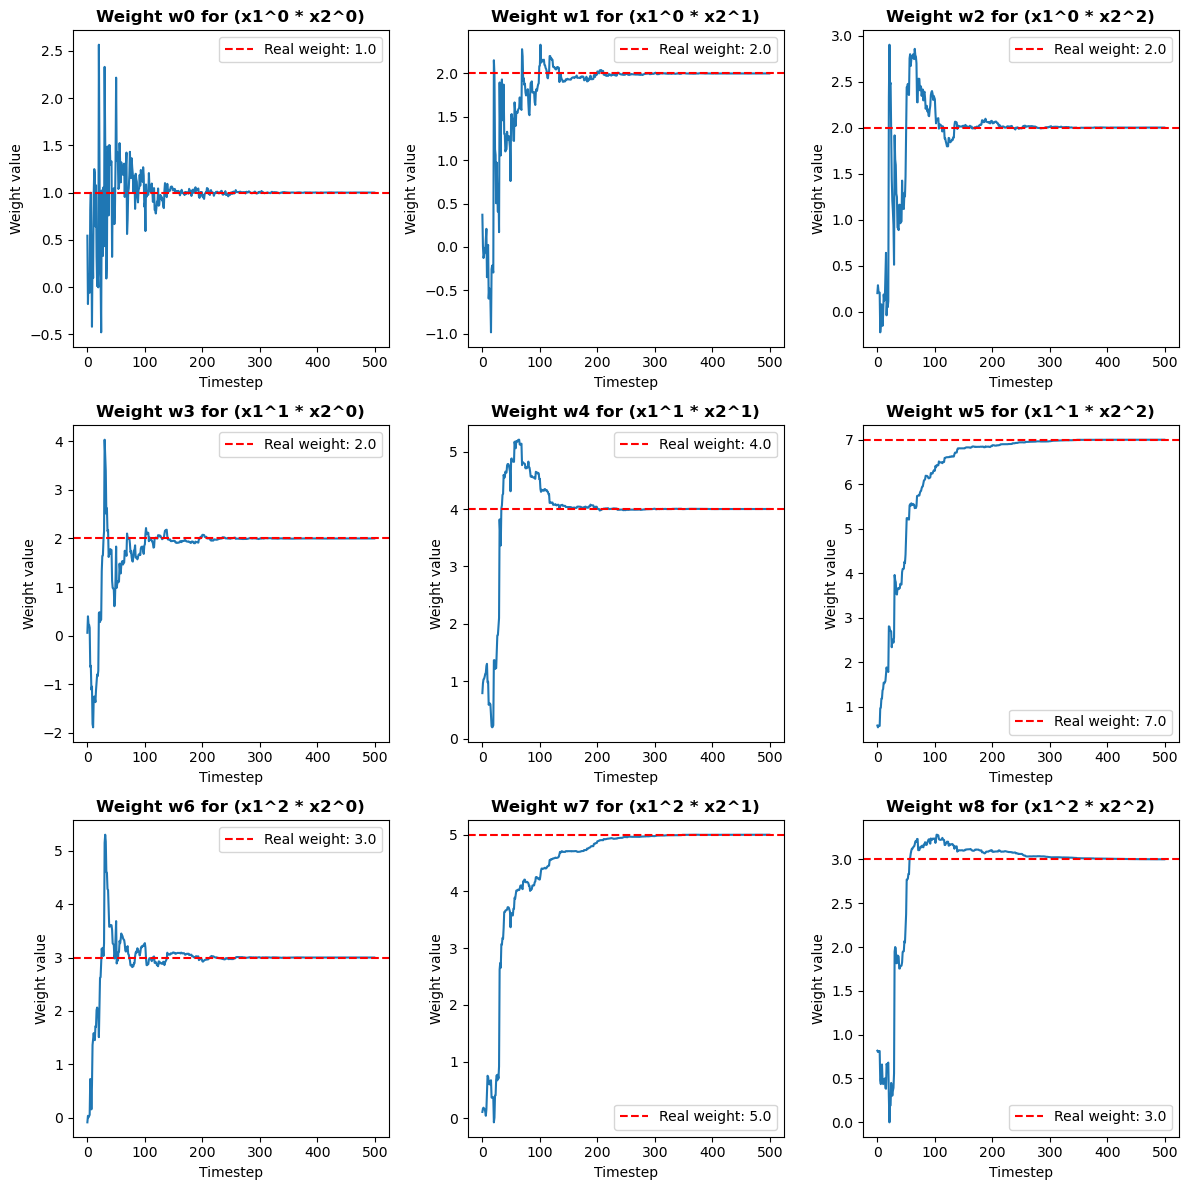

In [33]:
import math

# Determine the grid size
num_weights = weights_over_time.shape[1]
grid_size = math.ceil(math.sqrt(num_weights))

# Create a grid of subplots, one for each weight
fig, axs = plt.subplots(grid_size, grid_size, figsize=(4*grid_size, 4*grid_size))

# Flatten the axs for easier iteration
axs_flat = axs.flatten()

# Define the polynomial terms
polynomial_terms = []
for i in range(polynomial_degree+1):
    for j in range(polynomial_degree+1):
        polynomial_terms.append(f'x1^{i} * x2^{j}')

for i in range(num_weights):
    axs_flat[i].plot(weights_over_time[:, i])
    axs_flat[i].set_title(f'Weight w{i} for ({polynomial_terms[i]})', fontweight='bold')
    real_value = real_coeffs[i]
    axs_flat[i].axhline(y=real_value, linestyle='dashed', color='red', label=f"Real weight: {real_value:.1f}")
    axs_flat[i].set_xlabel('Timestep')
    axs_flat[i].set_ylabel('Weight value')
    axs_flat[i].legend()

# Remove empty subplots
if grid_size**2 > num_weights:
    for i in range(num_weights, grid_size**2):
        fig.delaxes(axs_flat[i])

plt.tight_layout()
plt.show()

In [34]:
# Do it off line. 

# For Y, use the legendre multi design matrix to come up with entire polynomial expansion. 
# Solve the problem using the design metrix and the measurement vector. 
    # Done

# Do this process with least square, for off line. 
# Mathematical distion, 1 vs all datapoints at once. 


# Compresse sensing, or compressive sampling. 
# Even for overdetermined, minimizing l1. Improves sparcity.